In [125]:
import pandas as pd
granularity = 50

if granularity == 50:


    df_cultura = pd.read_csv("../results_50/raw_results.csv", index_col = [0])

elif granularity == 10:


    df_cultura = pd.read_csv("../results_10/raw_results.csv", index_col = [0])


df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_min']  =  df_cultura['min_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_max']  =  df_cultura['max_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual

print(len(set(df_cultura.individual_wikidata_id)))

df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'N_est_min':'sum', 'N_est_max':'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura = df_cultura[df_cultura['decade'] <=1870]

df_cultura_world = df_cultura.drop('region_name', axis=1).groupby('decade').sum().reset_index()
df_cultura_world['region_name']='world'

df_cultura = pd.concat([df_cultura_world, df_cultura])


95955


# Index for Chinese World and Low Countries

In [126]:
df_cultura['survival_rate'] = df_cultura['score']/ df_cultura['N_est']
df_cultura['survival_rate_min'] = df_cultura['score']/ df_cultura['N_est_min']
df_cultura['survival_rate_max'] = df_cultura['score']/ df_cultura['N_est_max']

In [127]:
region_name = 'world'
df = df_cultura[df_cultura['region_name']==region_name]
df = df[df['decade']>=-500]
df.head(5)

,decade,N_est,N_est_min,N_est_max,score,region_name,survival_rate,survival_rate_min,survival_rate_max
5,-500,447.270235,329.086995,666.646417,44,world,0.098375,0.133703,0.066002
6,-450,599.884357,448.570066,870.459254,67,world,0.111688,0.149364,0.076971
7,-400,622.337276,472.174418,879.424738,64,world,0.102838,0.135543,0.072775
8,-350,594.280080,465.745637,804.996851,68,world,0.114424,0.146002,0.084472
9,-300,603.266129,470.962023,820.816294,62,world,0.102774,0.131645,0.075535


In [131]:
import plotly.graph_objects as go

# Create a plot
fig = go.Figure()

# Add trace for N_est with error bars on the left y-axis
fig.add_trace(go.Scatter(
    x=df['decade'], y=df['N_est'],
    mode='lines+markers',
    name='Corrected CPI',
    line=dict(color='royalblue'),
    yaxis='y1',  # Assign to the left y-axis
    error_y=dict(
        type='data',  # represent data variability
        symmetric=False,
        array=df['N_est_max'] - df['N_est'],
        arrayminus=df['N_est'] - df['N_est_min']
    )
))

# Add trace for score on the left y-axis
fig.add_trace(go.Scatter(
    x=df['decade'], y=df['score'],
    mode='lines+markers',
    name='CPI',
    line=dict(color='firebrick'),
    yaxis='y1'  # Keep on the left y-axis
))

# Add bar trace for survival_rate with error bars on the right y-axis
fig.add_trace(go.Bar(
    x=df['decade'], y=df['survival_rate'],
    name='Survival Rate',
    marker=dict(color='rgba(144, 238, 144, 0.5)'),
    yaxis='y2',  # Assign to the right y-axis
    error_y=dict(
        type='data',
        symmetric=False,
        array=df['survival_rate_max'] - df['survival_rate'],
        arrayminus=df['survival_rate'] - df['survival_rate_min'],
        color='lightgreen',  # Color of the error bars
        thickness=1.5,  # Set the thickness of the error bars (optional)
        width=10  # Set the width of the error bar caps (optional)
    )
))

fig.update_traces(texttemplate='%{y:.2f}%', textposition='outside', selector=dict(type='bar'))

# Customize the layout with a secondary y-axis
fig.update_layout(
    title=region_name,
    xaxis_title='',
    yaxis=dict(
        title='Number of CPs (Log Scale)',
        titlefont=dict(color='black'),
        tickfont=dict(color='black')
    ),
    yaxis2=dict(
        title='Survival Rate',
        titlefont=dict(color='white'),
        tickfont=dict(color='white'),
        anchor="free",
        overlaying="y",
        side="right",
        position=0.98
    ),
    legend_title='Metrics',
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="black"
    ),
    plot_bgcolor='white',
    hovermode="x unified"
)

fig.update_layout(yaxis_type='log')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=True)
fig.update_layout(
    margin=dict(t=50)  # Increase the top margin
)

# Show the figure
fig.show()

In [129]:
df_cultura['decade'] = df_cultura['decade'].astype(int)

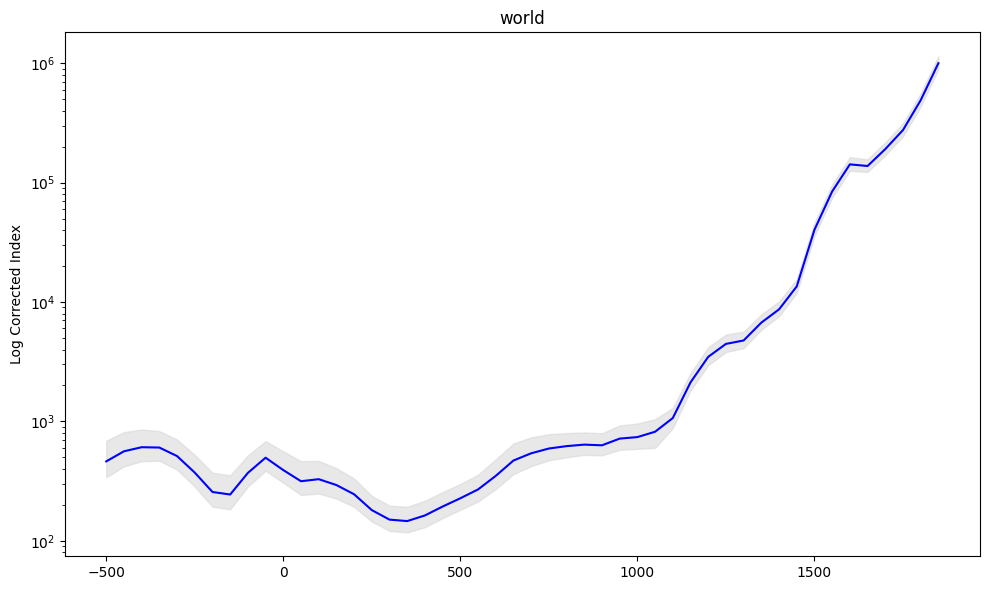

In [130]:


# Get unique region names
regions = df['region_name'].unique()

# Iterate through each region
for region in regions:
    # Subset data for the current region
    df_region = df[df['region_name'] == region]
    
    # Plot
    plt.figure(figsize=(10, 6))

    # Add LOESS regression lines for N_est, N_est_min, and N_est_max
    n = 0.1
    lowess = sm.nonparametric.lowess(df_region['N_est'], df_region['decade'], frac=n)
    plt.plot(lowess[:, 0], lowess[:, 1], label='N_est', color='blue')

    # Compute LOESS regressions for N_est_min and N_est_max
    lowess_min = sm.nonparametric.lowess(df_region['N_est_min'], df_region['decade'], frac=n)
    lowess_max = sm.nonparametric.lowess(df_region['N_est_max'], df_region['decade'], frac=n)

    # Fill between N_est_min and N_est_max LOESS regressions
    plt.fill_between(lowess_min[:, 0], lowess_min[:, 1], lowess_max[:, 1], color='lightgrey', alpha=0.5)

    # Set y-axis ticks to every 100
    plt.gca().yaxis.set_major_locator(MultipleLocator(100))
    
    # Set y-axis to log scale
    plt.yscale('log')

    # Add title and labels
    plt.title(region)
    plt.xlabel('')
    plt.ylabel('Log Corrected Index')

    # Show plot
    plt.tight_layout()
    plt.savefig(f'corrected_index/{region}.png')
    plt.show()
    
 
